In [103]:
import warnings 
warnings.filterwarnings('ignore')

In [104]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [105]:
from sklearn import preprocessing
labelEncoder=preprocessing.LabelEncoder()

## K-Nearest-Neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

## Overview

1.Read the problem statement.

2.Get the dataset.

3.Explore the dataset.

4.Pre-processing of dataset.

5.Visualization

6.Transform the dataset for building machine learning model.

7.Split data into train, test set.

7.Build Model.

8.Apply the model.

9.Evaluate the model.

10.Finding Optimal K value

11.Repeat 7,8,9 steps.

## Problem statement

### Dataset

The data set we’ll be using is the Iris Flower Dataset which was first introduced in 1936 by the famous statistician Ronald Fisher and consists of 50 observations from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals.

**Attributes of the dataset:** https://archive.ics.uci.edu/ml/datasets/Iris

**Train the KNN algorithm to be able to distinguish the species from one another given the measurements of the 4 features.**

## Question 1

Import the data set and print 10 random rows from the data set

In [106]:
iris = pd.read_csv("iris.csv").set_index('Id')
iris.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
21,5.4,3.4,1.7,0.2,Iris-setosa
16,5.7,4.4,1.5,0.4,Iris-setosa
105,6.5,3.0,5.8,2.2,Iris-virginica
136,7.7,3.0,6.1,2.3,Iris-virginica
88,6.3,2.3,4.4,1.3,Iris-versicolor
25,4.8,3.4,1.9,0.2,Iris-setosa
95,5.6,2.7,4.2,1.3,Iris-versicolor
62,5.9,3.0,4.2,1.5,Iris-versicolor
51,7.0,3.2,4.7,1.4,Iris-versicolor


## Data Pre-processing

## Question 2 - Estimating missing values

*Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median) *

In [107]:
iris[iris.isnull().any(axis=1)]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
151,5.9,NaN,NaN,NaN,Iris-virginica
152,NaN,NaN,NaN,1.8,Iris-virginica


In [108]:
df_iris = iris.groupby(['Species'],as_index=False).apply(lambda x: x.fillna(x.median()))
df_iris[df_iris.isnull().any(axis=1)]

,,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
,Id,,,,,


## Question 3 - Dealing with categorical data

Change all the classes to numericals (0to2).

In [109]:
df_iris['Species']= labelEncoder.fit_transform(df_iris['Species'])
df_iris['Species'].unique()
#nusinace column got added before Id - but this would affect in aggregations
#http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
df_iris.sample(5)

,,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
,Id,,,,,
2,113,6.8,3.0,5.5,2.1,2
0,42,4.5,2.3,1.3,0.3,0
1,90,5.5,2.5,4.0,1.3,1
0,12,4.8,3.4,1.6,0.2,0
2,125,6.7,3.3,5.7,2.1,2


## Question 4

*Observe the association of each independent variable with target variable and drop variables from feature set having correlation in range -0.1 to 0.1 with target variable.*

In [110]:
#No variables to be dropped as the correlation does not fall into the range of -0.1 to 0.1
df_iris.corr()['Species']

SepalLengthCm    0.780203
SepalWidthCm    -0.417318
PetalLengthCm    0.949609
PetalWidthCm     0.956433
Species          1.000000
Name: Species, dtype: float64

## Question 5

*Observe the independent variables variance and drop such variables having no variance or almost zero variance(variance < 0.1). They will be having almost no influence on the classification.*

In [111]:
df_iris.iloc[:,:-1].var()
#no variables have variance < 0.1 hence none to drop

SepalLengthCm    0.679466
SepalWidthCm     0.185552
PetalLengthCm    3.113888
PetalWidthCm     0.581262
dtype: float64

## Question 6

*Plot the scatter matrix for all the variables.*

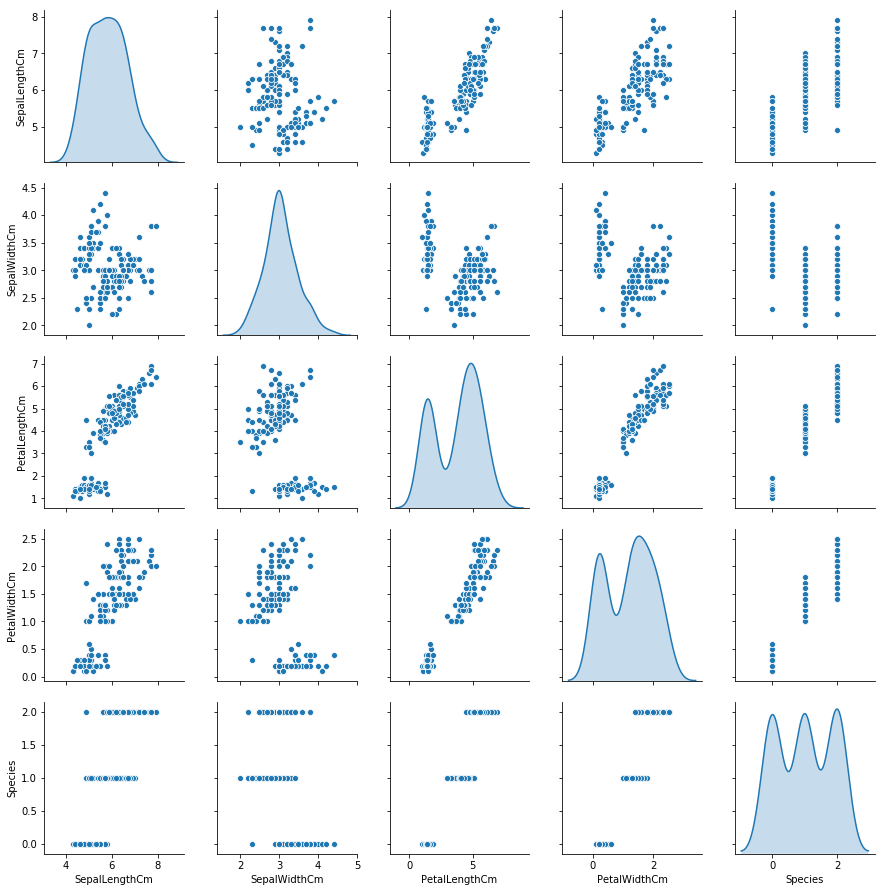

In [112]:
sns.pairplot(df_iris,diag_kind='kde')

## Split the dataset into training and test sets

## Question 7

*Split the dataset into training and test sets with 80-20 ratio.*

In [113]:
from scipy.stats import zscore
df_iris_zscore = df_iris.drop(['Species'] , axis = 1)
df_iris_zscore = df_iris_zscore.apply(zscore)
df_iris_zscore.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02
mean,-9.816709e-16,-8.180591e-16,-9.349247e-17,-9.349247e-17
std,1.003306e+00,1.003306e+00,1.003306e+00,1.003306e+00
min,-1.884203e+00,-2.453286e+00,-1.581889e+00,-1.457961e+00
25%,-9.104713e-01,-5.899533e-01,-1.240748e+00,-1.194766e+00
50%,-5.845594e-02,-1.241200e-01,3.512399e-01,1.212082e-01
75%,6.718429e-01,5.746298e-01,7.492370e-01,7.791954e-01
max,2.497590e+00,3.136713e+00,1.772658e+00,1.700377e+00


In [114]:
X = df_iris.drop(['Species'] , axis = 1)
Y = df_iris.pop('Species')

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

## Question 8 - Model

*Build the model and train and test on training and test sets respectively using **scikit-learn**. Print the Accuracy of the model with different values of **k=3,5,9**.*

**Hint:** For accuracy you can check **accuracy_score()** in scikit-learn

In [117]:
NNH = KNeighborsClassifier(n_neighbors= 5)
NNH.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [118]:
predicted_labels = NNH.predict(X_test)
print('accuracy score: ', metrics.accuracy_score(Y_test, predicted_labels))

accuracy score:  1.0


In [120]:
NNH = KNeighborsClassifier(n_neighbors= 13)
NNH.fit(X_train, Y_train)
predicted_labels = NNH.predict(X_test)
print('accuracy score: ', metrics.accuracy_score(Y_test, predicted_labels))

accuracy score:  1.0


In [121]:
NNH = KNeighborsClassifier(n_neighbors= 21)
NNH.fit(X_train, Y_train)
predicted_labels = NNH.predict(X_test)
print('accuracy score: ', metrics.accuracy_score(Y_test, predicted_labels))

accuracy score:  1.0


## Question 9 - Cross Validation

Run the KNN with no of neighbours to be 1,3,5..19 and *Find the **optimal number of neighbours** from the above list using the Mis classification error

Hint:

Misclassification error (MSE) = 1 - Test accuracy score. Calculated MSE for each model with neighbours = 1,3,5...19 and find the model with lowest MSE

In [124]:
NHH = KNeighborsClassifier(n_neighbors= 5)
scores = cross_val_score(NHH, X, y, cv=5)
display(scores)

array([0.96774194, 1.        , 0.93333333, 0.96666667, 1.        ])

## Question 10

*Plot misclassification error vs k (with k value on X-axis) using matplotlib.*

In [125]:
cv_scores = []
cv_scores.append(scores.mean())

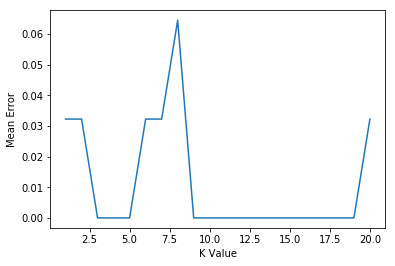

In [128]:
error = []

# Calculating error for K values between 1 and 21
for i in range(1, 21):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))
    
plt.plot(range(1, 21), error) 
plt.xlabel('K Value')  
plt.ylabel('Mean Error') 
plt.show()